# Coursework 2: Generative Models

## Instructions

Please submit on CATe two zip files:

*CW2.zip* containing the following:
1. A version of this notebook containing your answers. Write your answers in the cells below each question. **Please deliver the notebook including the outputs of the cells below.**
2. Your trained VAE model as *VAE_model.pth*

*GAN.zip* containing your trained Generator and Discriminator: *DCGAN_model_D.pth and DCGAN_model_G.pth*

Please avoid using markdown headings (# ## etc.) as these will affect the ToC. Instead use html headings if you want emphasis.

Similarly to the previous coursework, we recommend that you use Google Colaboratory in order to train the required networks.

TAs will run a testing cell (at the end of this notebook), so you are required to copy your transform and denorm functions to a cell near the bottom of the document (it is demarkated).

<font color="blue">**The deadline for submission is 19:00, Thursday 19th February, 2021** </font>

## Setting up working environment

For this coursework you, will need to train a large network, therefore we recommend you work with Google Colaboratory, which provides free GPU time. You will need a Google account to do so.

Please log in to your account and go to the following page: https://colab.research.google.com. Then upload this notebook.

For GPU support, go to "Edit" -> "Notebook Settings", and select "Hardware accelerator" as "GPU".

You will need to install pytorch and import some utilities by running the following cell:

In [ ]:
!pip install -q torch torchvision
!git clone -q https://github.com/afspies/icl_dl_cw2_utils
from icl_dl_cw2_utils.utils.plotting import plot_tsne
%load_ext google.colab.data_table

fatal: destination path 'icl_dl_cw2_utils' already exists and is not an empty directory.
The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


In [ ]:
from google.colab import drive
drive.mount('/content/drive') # Outputs will be saved in your google drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Introduction

For this coursework, you are asked to implement two commonly used generative models:
1. A **Variational Autoencoder (VAE)**
2. A **Deep Convolutional Generative Adversarial Network (DCGAN)**

For the first part you will the MNIST dataset https://en.wikipedia.org/wiki/MNIST_database and for the second the CIFAR-10 (https://www.cs.toronto.edu/~kriz/cifar.html).

Each part is worth 50 points. 

The emphasis of both parts lies in understanding how the models behave and learn, however, some points will be available for getting good results with your GAN (though you should not spend too long on this).

# Part 1 - Variational Autoencoder

## Part 1.1 (25 points)
**Your Task:**

a. Implement the VAE architecture with accompanying hyperparameters. Experiment with Feedforward and Convolutional Layers to see which gives better results.

b. Design an appropriate loss function and train the model.


In [30]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, sampler
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pickle

def show(img):
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))

if not os.path.exists('/content/drive/MyDrive/icl_dl_cw2/CW_VAE/'):
    os.makedirs('/content/drive/MyDrive/icl_dl_cw2/CW_VAE/')

# We set a random seed to ensure that your results are reproducible.
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
torch.manual_seed(0)

GPU = True # Choose whether to use GPU
if GPU:
    device = torch.device("cuda"  if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
print(f'Using {device}')

Using cuda


---
## Part 1.1a: Implement VAE (25 Points)
###Hyper-parameter selection


In [32]:
# Necessary Hyperparameters 
num_epochs = 20
learning_rate = 0.0005
batch_size = 64
latent_dim = 20 # Choose a value for the size of the latent space

# Additional Hyperparameters 


# (Optionally) Modify transformations on input
transform = transforms.Compose([
    transforms.ToTensor(),
])

# (Optionally) Modify the network's output for visualizing your images
def denorm(x):
    return x

### Data loading


In [33]:
train_dat = datasets.MNIST(
    "data/", train=True, download=True, transform=transform
)
test_dat = datasets.MNIST("data/", train=False, transform=transform)

loader_train = DataLoader(train_dat, batch_size, shuffle=True)
loader_test = DataLoader(test_dat, batch_size, shuffle=False)

# Don't change 
sample_inputs, _ = next(iter(loader_test))
fixed_input = sample_inputs[:32, :, :, :]
save_image(fixed_input, '/content/drive/MyDrive/icl_dl_cw2/CW_VAE/image_original.png')

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw





Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### Model Definition

<figure>
  <img src="https://blog.bayeslabs.co/assets/img/vae-gaussian.png" style="width:60%">
  <figcaption>
    Fig.1 - VAE Diagram (with a Guassian prior), taken from <a href="https://blog.bayeslabs.co/2019/06/04/All-you-need-to-know-about-Vae.html">1</a>.
  </figcaption>
</figure>


You will need to define:
* The hyperparameters
* The constructor
* encode
* reparametrize
* decode
* forward



Hints:
- It is common practice to encode the log of the variance, rather than the variance
- You might try using BatchNorm

In [35]:
# *CODE FOR PART 1.1a IN THIS CELL*

class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################

        # Create the encoder as a fully connected network with one hidden layer
        self.encoder = nn.Sequential(
            nn.Linear(784, latent_dim ** 2),
            nn.ReLU(),
            nn.Linear(latent_dim ** 2, latent_dim * 2)
        )

        # Create the decoder again as a fully connected network with one hidden layer and sigmoid output activation because images are normalised from 0 to 1
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, latent_dim ** 2),
            nn.ReLU(),
            nn.Linear(latent_dim ** 2, 784),
            nn.Sigmoid()
        )

        pass

        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 
        
    def encode(self, x):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################

        flattened_input_to_encoder = x.view(-1, 784)
        separated_encoder_output = self.encoder(flattened_input_to_encoder).view(-1, 2, latent_dim)
        mu = separated_encoder_output[:, 0, :]
        logvar = separated_encoder_output[:, 1, :]

        return mu, logvar

        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 
    
    def reparametrize(self, mu, logvar):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################

        if self.training:

          sigma = torch.exp(logvar * 0.5)
          epsilon = torch.normal(mean=0, std=1, size=(sigma.size())).to(device)

          z = epsilon * sigma + mu
          return z
        else:
          return mu

        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 

    def decode(self, z):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################

        x_hat_flat = self.decoder(z)
        x_hat = x_hat_flat.view(-1, 1, 28, 28)

        return x_hat

        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 
    
    def forward(self, x):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        x_hat = self.decode(z)

        return x_hat, mu, logvar

        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 

model = VAE(latent_dim).to(device)
params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of parameters is: {}".format(params))
print(model)
# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Total number of parameters is: 652824
VAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=400, bias=True)
    (1): ReLU()
    (2): Linear(in_features=400, out_features=40, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=400, bias=True)
    (1): ReLU()
    (2): Linear(in_features=400, out_features=784, bias=True)
    (3): Sigmoid()
  )
)


--- 

## Part 1.1b: Training the Model (5 Points)

### Defining a Loss
Recall the Beta VAE loss, with an encoder $q$ and decoder $p$:
$$ \mathcal{L}=\mathbb{E}_{q_\phi(z \mid X)}[\log p_\theta(X \mid z)]-\beta D_{K L}[q_\phi(z \mid X) \| p_\theta(z)]$$

In order to implement this loss you will need to think carefully about your model's outputs and the choice of prior.

There are multiple accepted solutions. Explain your design choices based on the assumptions you make regarding the distribution of your data.

* Hint: this refers to the log likelihood as mentioned in the tutorial. Make sure these assumptions reflect on the values of your input data, i.e. depending on your choice you might need to do a simple preprocessing step.

* You are encouraged to experiment with the weighting coefficient $\beta$ and observe how it affects your training

In [36]:
# *CODE FOR PART 1.1b IN THIS CELL*
save_log = False

def loss_function_VAE(recon_x, x, mu, logvar, beta):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################

        # Final choice of loss explained in Loss Explanation Question.
        # Note that both KL_divergence and reconstruction_loss output sum of losses for all outputs in batch.
        reconstruction_loss = F.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction="sum")
        KL_divergence = beta/2 * torch.sum(torch.exp(logvar) - logvar - 1 + mu ** 2)
        loss = KL_divergence + reconstruction_loss

        return loss, reconstruction_loss, KL_divergence
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 

model.train()
log = []
log_TSNE = {"mean":[], "logvar":[], "label":[]}
for epoch in range(num_epochs):     
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################

        # The effect of beta is explained in my answer to question below
        beta = 10
        # Training
        if epoch > 0:

          train_loss = 0
          reconstruction_loss = 0
          KL_divergence = 0

          for x, _ in loader_train:
            x = x.to(device)

            x_hat, mu, logvar = model(x)
            total_loss_batch, reconstruction_loss_batch, KL_divergence_batch = loss_function_VAE(x_hat, x, mu, logvar, beta)
            train_loss += total_loss_batch.item()
            reconstruction_loss += reconstruction_loss_batch.item()
            KL_divergence += KL_divergence_batch.item()

            optimizer.zero_grad()
            total_loss_batch.backward()
            optimizer.step()
        
          print("epoch: {} of training ===> total loss = {}, reconstruction loss = {}, KL divergence = {}".format(epoch, train_loss / len(train_dat), reconstruction_loss / len(train_dat), KL_divergence / len(train_dat)))
          log.append([train_loss / len(train_dat), reconstruction_loss / len(train_dat), KL_divergence / len(train_dat)])

        # Testing (added this here because later we are told to plot losses and didn't know where to do the testing)

        # Storing these for use in customised TSNE plot
        means, logvars, labels = [], [], []
        with torch.no_grad():

          model.eval()
          test_loss = 0
          reconstruction_loss = 0
          KL_divergence = 0

          for x, label in loader_test:
            x = x.to(device)

            x_hat, mu, logvar = model(x)
            total_loss_batch, reconstruction_loss_batch, KL_divergence_batch = loss_function_VAE(x_hat, x, mu, logvar, beta)
            test_loss += total_loss_batch.item()
            reconstruction_loss += reconstruction_loss_batch.item()
            KL_divergence += KL_divergence_batch.item()

            means.append(mu.detach())
            logvars.append(logvar.detach())
            labels.append(label.detach())

        print("epoch: {} of testing ===> total loss = {}, reconstruction loss = {}, KL divergence = {}".format(epoch, test_loss / len(test_dat), reconstruction_loss / len(test_dat), KL_divergence / len(test_dat)))
        # Storing this for use in losses plot
        log.append([test_loss / len(test_dat), reconstruction_loss / len(test_dat), KL_divergence / len(test_dat)])


        # Storing these for use in customised TSNE plot
        log_TSNE["mean"].append(torch.cat(means))
        log_TSNE["logvar"].append(torch.cat(logvars))
        log_TSNE["label"].append(torch.cat(labels))

        # Saving these for loss and TSNE plot with different betas
        if save_log:
          with open("log_for_loss_plot_beta_{}.pki".format(beta), "wb") as f:
            pickle.dump(log, f)
          with open("log_for_TSNE_plot_beta_{}.pki".format(beta), "wb") as f:
            pickle.dump(log_TSNE, f)

        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 
        
        # save the model
        if epoch == num_epochs - 1:
            # I think that to save it I need to do
            data = x
            with torch.no_grad():
                torch.jit.save(torch.jit.trace(model, (data), check_trace=False),
                    '/content/drive/MyDrive/icl_dl_cw2/CW_VAE/VAE_model.pth')


epoch: 0 of testing ===> total loss = 545.5053223632813, reconstruction loss = 544.244289453125, KL divergence = 1.261032681465149
epoch: 1 of training ===> total loss = 152.4426114501953, reconstruction loss = 140.001956640625, KL divergence = 12.44065494181315
epoch: 1 of testing ===> total loss = 106.03262204589844, reconstruction loss = 98.03996723632812, KL divergence = 7.992654679870605
epoch: 2 of training ===> total loss = 98.085208984375, reconstruction loss = 91.3601610921224, KL divergence = 6.72504784342448
epoch: 2 of testing ===> total loss = 90.72425897216797, reconstruction loss = 84.97305872802734, KL divergence = 5.751200393676758
epoch: 3 of training ===> total loss = 88.80944455159505, reconstruction loss = 83.94359234619141, KL divergence = 4.865852267201742
epoch: 3 of testing ===> total loss = 85.48288299560546, reconstruction loss = 81.34882814941406, KL divergence = 4.134054849243164
epoch: 4 of training ===> total loss = 85.01406296386719, reconstruction loss 

### Loss Explanation
Explain your choice of loss and how this relates to:

* The VAE Prior
* The output data domain
* Disentanglement in the latent space


**YOUR ANSWER**

The reconstruction term enforces the reconstructed output to be similar to the input. At the same time though, it is accidentally pushing the variance of z to collapse, which would make the autoencoder deterministic. Given that we are using MNIST, and each pixel in images is either black or white (domain between 0 and 1) I have decided to use a binary cross entropy.

Within the KL-diversion term:


*   (torch.exp(logvar) - logvar - 1) is minimised when the variance of z is 1, so it enforces the variance of z to be 1 (i.e. close to the VAE prior qφ(z).
*   (mu ** 2) is minimised when the mean of z is 0, so again it enforces the mean of z to be zero (i.e. closer to the prior)


Disentanglement in the latent space refers to ensuring that each element of z in the latent space encodes information relating to a different feature in the input image space. Thus, overfitting is avoided. This is achieved through beta. The larger beta, the more the disentanglement since more emphasis is placed on the part of the loss that deals with the distribution of z. The tradeoff is that too high beta results in deterioration of the quality of reconstructed images as the importance of the reconstruction part of the loss is reduced.


<h2>Part 1.2 (9 points)</h2>

a. Plot your loss curves

b. Show reconstructions and samples

c. Discuss your results from parts (a) and (b)

## Part 1.2a: Loss Curves (3 Points)
Plot your loss curves (6 in total, 3 for the training set and 3 for the test set): total loss, reconstruction log likelihood loss, KL loss (x-axis: epochs, y-axis: loss). If you experimented with different values of $\beta$, you may wish to display multiple plots (worth 1 point).

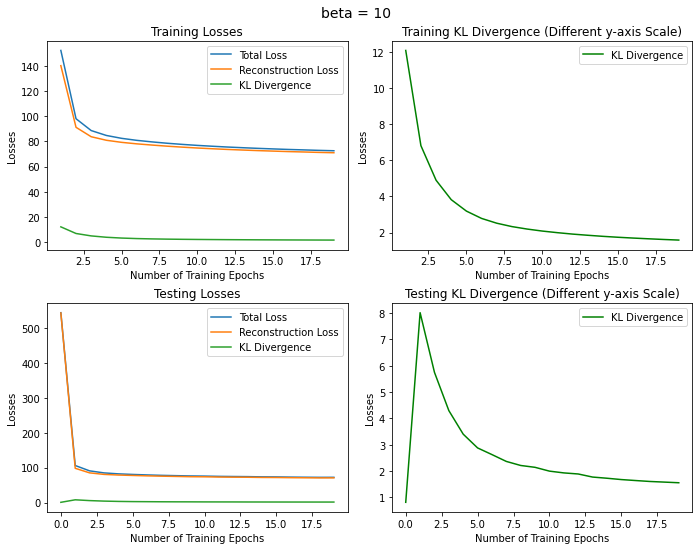

In [ ]:
# *CODE FOR PART 1.2a IN THIS CELL*
epoch = list(range(num_epochs))
epoch_no_zero = epoch[1:]
test_total_loss = [i[0] for i in log[::2]]
test_reconstruction_loss = [i[1] for i in log[::2]]
test_KL_div = [i[2] for i in log[::2]]
train_total_loss = [i[0] for i in log[1::2]]
train_reconstruction_loss = [i[1] for i in log[1::2]]
train_KL_div = [i[2] for i in log[1::2]]

fig, axs = plt.subplots(2,2, figsize=(10,8))
st = fig.suptitle("beta = {}".format(beta), fontsize=14)

axs[0,0].plot(epoch_no_zero, train_total_loss, label="Total Loss")
axs[0,0].plot(epoch_no_zero, train_reconstruction_loss, label="Reconstruction Loss")
axs[0,0].plot(epoch_no_zero, train_KL_div, label="KL Divergence")
axs[0,0].legend(loc="upper right")
axs[0,0].title.set_text("Training Losses")
axs[0,0].set_xlabel("Number of Training Epochs")
axs[0,0].set_ylabel("Losses")

axs[0,1].plot(epoch_no_zero, train_KL_div, 'g', label="KL Divergence")
axs[0,1].legend(loc="upper right")
axs[0,1].title.set_text("Training KL Divergence (Different y-axis Scale)")
axs[0,1].set_xlabel("Number of Training Epochs")
axs[0,1].set_ylabel("Losses")

axs[1,0].plot(epoch, test_total_loss, label="Total Loss")
axs[1,0].plot(epoch, test_reconstruction_loss, label="Reconstruction Loss")
axs[1,0].plot(epoch, test_KL_div, label="KL Divergence")
axs[1,0].legend(loc="upper right")
axs[1,0].title.set_text("Testing Losses")
axs[1,0].set_xlabel("Number of Training Epochs")
axs[1,0].set_ylabel("Losses")

axs[1,1].plot(epoch, test_KL_div, 'g', label="KL Divergence")
axs[1,1].legend(loc="upper right")
axs[1,1].title.set_text("Testing KL Divergence (Different y-axis Scale)")
axs[1,1].set_xlabel("Number of Training Epochs")
axs[1,1].set_ylabel("Losses")

plt.tight_layout()
st.set_y(0.95)
fig.subplots_adjust(top=0.89)
plt.show()


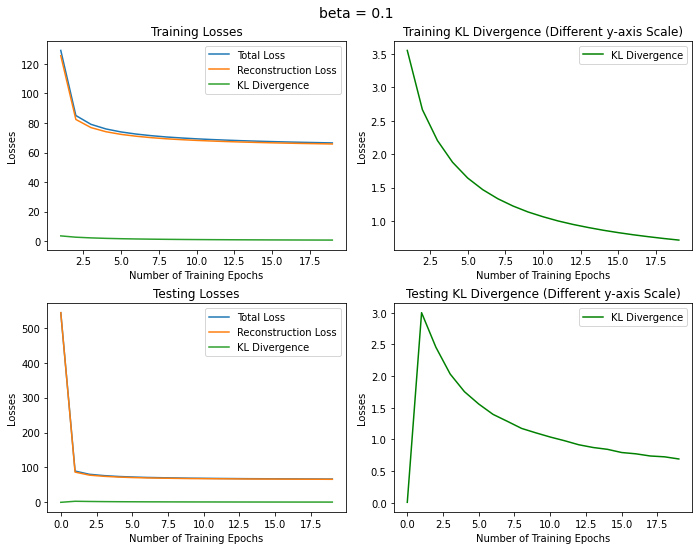

In [ ]:
# *CODE FOR PART 1.2a IN THIS CELL* Different beta
with open("log_for_loss_plot_beta_0.1.pki", "rb") as f:
  log2 = pickle.load(f)

epoch = list(range(num_epochs))
epoch_no_zero = epoch[1:]
test_total_loss = [i[0] for i in log2[::2]]
test_reconstruction_loss = [i[1] for i in log2[::2]]
test_KL_div = [i[2] for i in log2[::2]]
train_total_loss = [i[0] for i in log2[1::2]]
train_reconstruction_loss = [i[1] for i in log2[1::2]]
train_KL_div = [i[2] for i in log2[1::2]]

fig, axs = plt.subplots(2,2, figsize=(10,8))
st = fig.suptitle("beta = 0.1", fontsize=14)

axs[0,0].plot(epoch_no_zero, train_total_loss, label="Total Loss")
axs[0,0].plot(epoch_no_zero, train_reconstruction_loss, label="Reconstruction Loss")
axs[0,0].plot(epoch_no_zero, train_KL_div, label="KL Divergence")
axs[0,0].legend(loc="upper right")
axs[0,0].title.set_text("Training Losses")
axs[0,0].set_xlabel("Number of Training Epochs")
axs[0,0].set_ylabel("Losses")

axs[0,1].plot(epoch_no_zero, train_KL_div, 'g', label="KL Divergence")
axs[0,1].legend(loc="upper right")
axs[0,1].title.set_text("Training KL Divergence (Different y-axis Scale)")
axs[0,1].set_xlabel("Number of Training Epochs")
axs[0,1].set_ylabel("Losses")

axs[1,0].plot(epoch, test_total_loss, label="Total Loss")
axs[1,0].plot(epoch, test_reconstruction_loss, label="Reconstruction Loss")
axs[1,0].plot(epoch, test_KL_div, label="KL Divergence")
axs[1,0].legend(loc="upper right")
axs[1,0].title.set_text("Testing Losses")
axs[1,0].set_xlabel("Number of Training Epochs")
axs[1,0].set_ylabel("Losses")

axs[1,1].plot(epoch, test_KL_div, 'g', label="KL Divergence")
axs[1,1].legend(loc="upper right")
axs[1,1].title.set_text("Testing KL Divergence (Different y-axis Scale)")
axs[1,1].set_xlabel("Number of Training Epochs")
axs[1,1].set_ylabel("Losses")

plt.tight_layout()
st.set_y(0.95)
fig.subplots_adjust(top=0.89)
plt.show()

## Part 1.2b: Samples and Reconstructions (6 Points)
Visualize a subset of the images of the test set and their reconstructions **as well as** a few generated samples. Most of the code for this part is provided. You only need to call the forward pass of the model for the given inputs (might vary depending on your implementation).

Input images
--------------------------------------------------
Reconstructed images
--------------------------------------------------
Generated Images
--------------------------------------------------


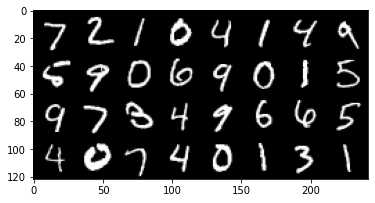

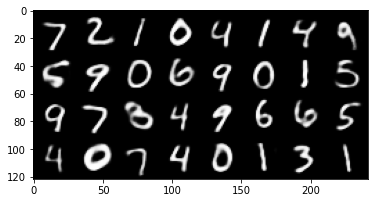

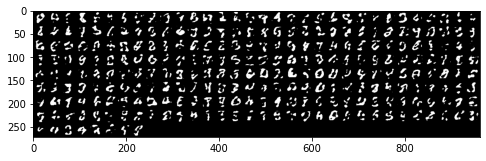

In [ ]:
# *CODE FOR PART 1.2b IN THIS CELL*

# load the model
print('Input images')
print('-'*50)

sample_inputs, _ = next(iter(loader_test))
fixed_input = sample_inputs[0:32, :, :, :]
# visualize the original images of the last batch of the test set
img = make_grid(denorm(fixed_input), nrow=8, padding=2, normalize=False,
                range=None, scale_each=False, pad_value=0)
plt.figure()
show(img)

print('Reconstructed images')
print('-'*50)
with torch.no_grad():
    # visualize the reconstructed images of the last batch of test set
    
    #######################################################################
    #                       ** START OF YOUR CODE **
    #######################################################################
    fixed_input = fixed_input.to(device)
    recon_batch, _, _ = model(fixed_input)
    #######################################################################
    #                       ** END OF YOUR CODE **
    ####################################################################### 
    
    recon_batch = recon_batch.cpu()
    recon_batch = make_grid(denorm(recon_batch), nrow=8, padding=2, normalize=False,
                            range=None, scale_each=False, pad_value=0)
    plt.figure()
    show(recon_batch)

print('Generated Images')  
print('-'*50)
model.eval()
n_samples = 264
z = torch.randn(n_samples,latent_dim).to(device)
with torch.no_grad():
    #######################################################################
    #                       ** START OF YOUR CODE **
    #######################################################################
    samples = model.decode(z)
    #######################################################################
    #                       ** END OF YOUR CODE **
    ####################################################################### 
    
    samples = samples.cpu()
    samples = make_grid(denorm(samples), nrow=32, padding=2, normalize=False,
                            range=None, scale_each=False, pad_value=0)
    plt.figure(figsize = (8,8))
    show(samples)



### Discussion
Provide a brief analysis of your loss curves and reconstructions: 
* What do you observe in the behaviour of the log-likelihood loss and the KL loss (increasing/decreasing)?
* Can you intuitively explain if this behaviour is desirable? Have you observed posterior collapse during traing (i.e. when the KL is too small during the early stages of training)? 
    * If yes, how did you mitigate it? How did this phenomenon reflect on your output samples?
    * If no, why do you think that is?

**YOUR ANSWER**

In the 0th epoch of training, that is before any training had occured, (given my implementation), KL divergence collapsed to a very small value. Since the encoder had not yet been trained, it was producing means and variances irrelevant to its input x. At the same time, the untrained decoder was naturally randomly producing predictions x_hat. KL divergence between the closely initialised posterior and prior distributions was small. However, since training had not yet started, and since posterior collapse refers to the collapse of the posterior distribution to a normal distribution during training, the phenomenon described above does not constitute a posterior collapse.

Overall, the losses are decreasing over training, which is desirable. Intuitivly, I would say that the avoidance of posterior collapse may be attributed to the large value of 10 that I have assigned beta, thus putting emphasis on the KL divergence part of the loss. On a second thought, I am not too sure about that: a large beta could mean that the model is trying to optimise a KL divergence which is doomed to be large and therefore have more motivation to just let it collapse. Anyway, I am not too sure to be honest. It is worth noting though that a large beta comes at the cost of deteriorating the quality of decoded images due to having decreased the effect of reconstruction loss on the total loss.

Update:
What seems to cause posterior collapse is training the model with a small beta (so that it learns not to put importance in keeping KL divergence pre multiplication with beta low) and then changing beta to a high value (so that gradually the model has to re-learn that keeping KL divergence low is important). I am not sure this classifies as posterior collapse though.

---
<h2> Part 1.3 (11 points) <h2/>

Qualitative analysis of the learned representations

In this question you are asked to qualitatively assess the representations that your model has learned. In particular:

a. Dimensionality Reduction of learned embeddings

b. Interpolating in the latent space

## Part 1.3a: T-SNE on Embeddings (7 Points)
Extract the latent representations of the test set and visualize them using [T-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding)  [(see implementation)](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html). 

We've provided a function to visualize a subset of the data, but you are encouraged to also produce a matplotlib plot (please use different colours for each digit class).

In [ ]:
# *CODE FOR PART 1.3a IN THIS CELL
from icl_dl_cw2_utils.utils.plotting import plot_tsne
from sklearn import manifold

model.eval()

test_dataloader = DataLoader(test_dat, 10000, shuffle=False)
x, labels = next(iter(test_dataloader))
x = x.to(device)

mu, logvar = model.encode(x)
z = model.reparametrize(mu, logvar)
z = z.cpu()

z_embedded = sklearn.manifold.TSNE(n_components=2).fit_transform(z.detach().numpy())


In [ ]:
# Interactive Visualization - Code Provided
#test_dataloader = DataLoader(test_dat, 10000, shuffle=False)
""" Inputs to the function are
        z_embedded - X, Y positions for every point in test_dataloader
        test_dataloader - dataloader with batchsize set to 10000
        num_points - number of points plotted (will slow down with >1k)
"""
plot_tsne(z_embedded, test_dataloader, num_points=1000, darkmode=False)


Output hidden; open in https://colab.research.google.com to view.

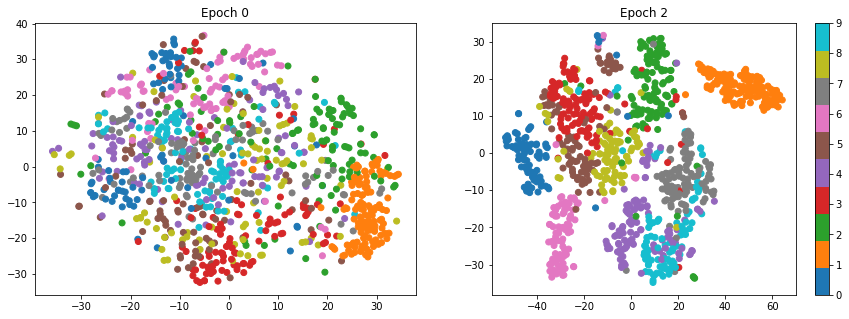

In [ ]:
# Custom Visualizations
N = 1000
X, Y, L = [], [], []
epochss = (0, 2)

for epoch in epochss:
  X.append(log_TSNE["mean"][epoch][:N].cpu())
  Y.append(log_TSNE['label'][epoch][:N])
  L.append(manifold.TSNE(n_components=2).fit_transform(X[-1]))

fig, axs = plt.subplots(ncols=2)
for idx, epoch in enumerate(epochss):
   s = axs[idx].scatter(L[idx][:, 0], L[idx][:, 1], c=Y[idx], cmap="tab10")
   axs[idx].set_title("Epoch {}".format(epoch))
fig.set_figheight(5)
fig.set_figwidth(15)
fig.colorbar(s)

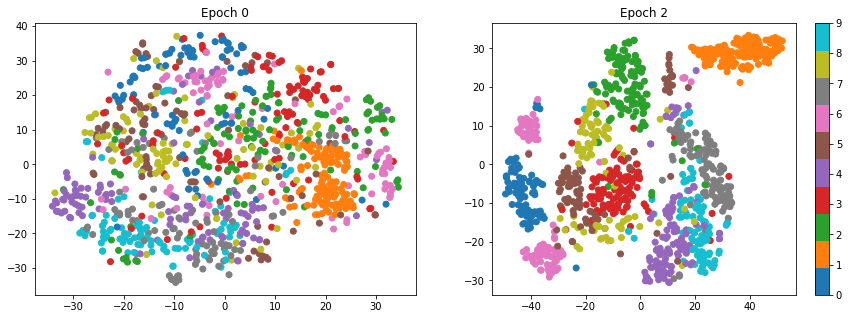

In [ ]:
# Custom Visualizations different beta
with open("log_for_TSNE_plot_beta_0.1.pki", "rb") as f:
  log_TSNE2 = pickle.load(f)

N = 1000
X, Y, L = [], [], []
epochss = (0, 2)

for epoch in epochss:
  X.append(log_TSNE2["mean"][epoch][:N].cpu())
  Y.append(log_TSNE2['label'][epoch][:N])
  L.append(manifold.TSNE(n_components=2).fit_transform(X[-1]))

fig, axs = plt.subplots(ncols=2)
for idx, epoch in enumerate(epochss):
   s = axs[idx].scatter(L[idx][:, 0], L[idx][:, 1], c=Y[idx], cmap="tab10")
   axs[idx].set_title("Epoch {}".format(epoch))
fig.set_figheight(5)
fig.set_figwidth(15)
fig.colorbar(s)

### Discussion
What do you observe? Discuss the structure of the visualized representations. 
* What do you observe? What role do the KL loss term and $\beta$ have, if any, in what you observe (multiple matplotlib plots may be desirable here)?
    * Consider Outliers
    * Counsider Boundaries
    * Consider Clusters
* Is T-SNE reliable? What happens if you change the parameters (don't worry about being particularly thorough). [This link](https://distill.pub/2016/misread-tsne/) may be helpful.

**YOUR ANSWER**

As expected, the T-SNE plot of low dimensional representations of digits is rather arbitrary in epoch 0, before any training has occured. In epoch 2, after two epochs of training, the low dimensional representations of same digits are already clustered together.

It is the KL-divergence term that forces distributions output from the encoder to to have a mean close to zero, (so that same-digit clusters do not end up being very far from one another), and non-zero variance, (so that distributions do not end up being just a point). The larger beta, the higher the emphasis on the KL-divergence part of the loss. Therefore, I would expect that higher beta should yield a clearer clustering of same digits in the T-SNE plot. However, such an effect does not seem discernible in the above T-SNE plots.

In terms of outliers, there are a few in all three TSNE plots above. These are mostly due to some people writing digits in different ways. For example in the first, not customised T-SNE, there is a 2 between the 0s and if we hover our mouse above it we see that this 2 is written a lot like a 0. Interestingly, in the last plot, 5s seem to have formed two clusters. This may be because there are two distinct ways of writing a 5.

T-SNE plots are not always perfectly reliable. They are sensitive to hyperparameters such as perplexity and number of iterations and changing these can make the difference between an insightful and a meaningless plot. Additional alarming facts are that cluster sizes in T-SNE plot mean nothing, distances between clusters may also mean nothing, random noise does not always seem random, and more.

## Part 1.3b: Interpolating in $z$ (4 Points)
Perform a linear interpolation in the latent space of the autoencoder by choosing any two digits from the test set. What do you observe regarding the transition from on digit to the other?


We will interpolate between these two digits:


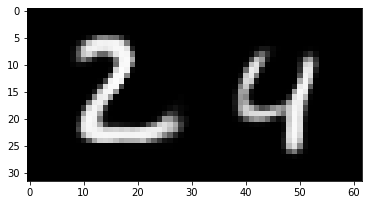

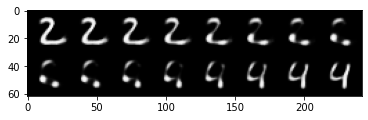

In [ ]:
# CODE FOR PART 1.3b IN THIS CELL

# Digits between which to interpolate
a, b = 2, 5
print("We will interpolate between these two digits:")
sample = model.decode(torch.stack((mu[a-1].data, mu[b-1].data), 0))
img = make_grid(denorm(sample.detach().cpu()), nrow=8, padding=2, normalize=False,
                range=None, scale_each=False, pad_value=0)
plt.figure()
show(img)

# Interpolation
insterpolation_steps = 16
digit = torch.Tensor(insterpolation_steps, latent_dim).to(device)
for step in range(insterpolation_steps):
  digit[step] = step / (insterpolation_steps - 1) * mu[b - 1].data + (1 - step / (insterpolation_steps - 1)) * mu[a - 1].data
sample = model.decode(digit)
img = make_grid(denorm(sample.detach().cpu()), nrow=8, padding=2, normalize=False,
                range=None, scale_each=False, pad_value=0)
plt.figure()
show(img)

### Discussion
What did you observe in the interpolation? Is this what you expected?
* Can you relate the interpolation to your T-SNE visualization

**YOUR ANSWER**

If for example I choose to interpolate between the digits 2 and 4, I see a 2 gradually changing to eventually become a 4. This is what I expect.

Interestingly, somewhere in the middle, the interpolation looks a bit like a 9. This makes sense since, as the TSNE plots above verify, 9 is sort of in between a 4 and a 2. Put more formally, it seems that the lower dimensional representation of nine shares some features with the lower dimensional representations of both the 4 and the 2.

# Part 2 - Deep Convolutional GAN

In this task, your main objective is to train a DCGAN (https://arxiv.org/abs/1511.06434) on the CIFAR-10 dataset. You should experiment with different architectures, tricks for stability in training (such as using different activation functions, batch normalization, different values for the hyper-parameters, etc.). In the end, you should provide us with: 

- your best trained model (which we will be able to run), 
- some generations for the fixed latent vectors $\mathbf{z}\sim \mathcal{N}\left(\mathbf{0}, \mathbf{I}\right)$ we have provided you with (train for a number of epochs and make sure there is no mode collapse), 
- plots with the losses for the discriminator $D$ and the generator $G$ as the training progresses and explain whether your produced plots are theoretically sensible and why this is (or not) the case. 
- a discussion on whether you noticed any mode collapse, where this behaviour may be attributed to, and explanations of what you did in order to cope with mode collapse. 

## Part 2.1 (30 points)
**Your Task**: 

a. Implement the DCGAN architecture. 

b. Define a loss and implement the Training Loop

c. Visualize images sampled from your best model's generator ("Extension" Assessed on quality)

d. Discuss the experimentations which led to your final architecture. You can plot losses or generated results by other architectures that you tested to back your arguments (but this is not necessary to get full marks).


_Clarification: You should not be worrying too much about getting an "optimal" performance on your trained GAN. We want you to demonstrate to us that you experimented with different types of DCGAN variations, report what difficulties transpired throughout the training process, etc. In other words, if we see that you provided us with a running implementation, that you detail different experimentations that you did before providing us with your best one, and that you have grapsed the concepts, you can still get good marks. The attached model does not have to be perfect, and the extension marks for performance are only worth 10 points._

In [13]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
from torch.optim.lr_scheduler import StepLR, MultiStepLR
import torch.nn.functional as F
import matplotlib.pyplot as plt


def denorm(x, channels=None, w=None ,h=None, resize = False):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    if resize:
        if channels is None or w is None or h is None:
            print('Number of channels, width and height must be provided for resize.')
        x = x.view(x.size(0), channels, w, h)
    return x

def show(img):
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))

if not os.path.exists('/content/drive/MyDrive/icl_dl_cw2/CW_GAN'):
    os.makedirs('/content/drive/MyDrive/icl_dl_cw2/CW_GAN')

GPU = True # Choose whether to use GPU
if GPU:
    device = torch.device("cuda"  if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
print(f'Using {device}')

# We set a random seed to ensure that your results are reproducible.
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
torch.manual_seed(0)

Using cuda


### Part 2.1a: Implement DCGAN (8 Points)
Fill in the missing parts in the cells below in order to complete the Generator and Discriminator classes. You will need to define:

- The hyperparameters
- The constructors
- `decode`
- `discriminator`

Recomendations for experimentation:
- use the architecture that you implemented for the Autoencoder of Part 1 (encoder as discriminator, decoder as generator).
- use the architecture desribed in the DCGAN paper (https://arxiv.org/abs/1511.06434).

Some general reccomendations:
- add several convolutional layers (3-4).
- accelerate training with batch normalization after every convolutional layer.
- use the appropriate activation functions. 
- Generator module: the upsampling can be done with various methods, such as nearest neighbor upsampling (`torch.nn.Upsample`) or transposed convolutions(`torch.nn.ConvTranspose2d`). 
- Discriminator module: Experiment with batch normalization (`torch.nn.BatchNorm2d`) and leaky relu (`torch.nn.LeakyReLu`) units after each convolutional layer.

Try to follow the common practices for CNNs (e.g small receptive fields, max pooling, RELU activations), in order to narrow down your possible choices.

<font color="red">**Your model should not have more than 25 Million Parameters**</font>

The number of epochs that will be needed in order to train the network will vary depending on your choices. As an advice, we recommend that while experimenting you should allow around 20 epochs and if the loss doesn't sufficiently drop, restart the training with a more powerful architecture. You don't need to train the network to an extreme if you don't have the time.

#### Data loading

In [14]:
batch_size = 128# change that

transform = transforms.Compose([
     transforms.ToTensor(),
     transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5),),                        
])

data_dir = './datasets'

cifar10_train = datasets.CIFAR10(data_dir, train=True, download=True, transform=transform)
cifar10_test = datasets.CIFAR10(data_dir, train=False, download=True, transform=transform)
loader_train = DataLoader(cifar10_train, batch_size=batch_size)
loader_test = DataLoader(cifar10_test, batch_size=batch_size)

Files already downloaded and verified
Files already downloaded and verified


We'll visualize a subset of the test set: 

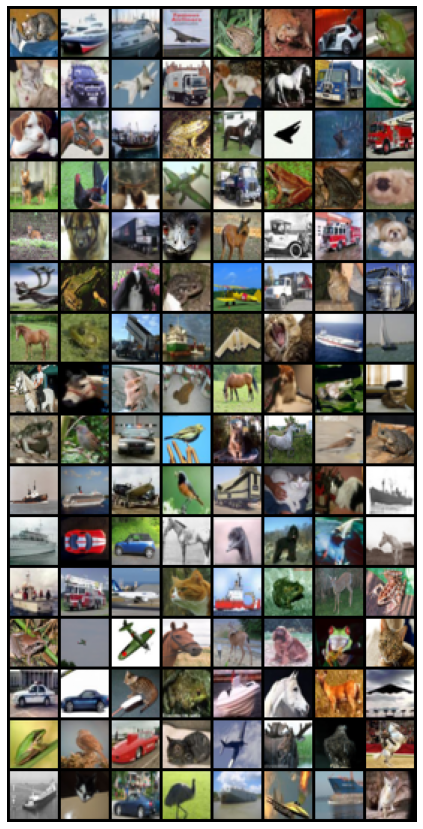

In [15]:
samples, _ = next(iter(loader_test))

samples = samples.cpu()
samples = make_grid(denorm(samples), nrow=8, padding=2, normalize=False,
                        range=None, scale_each=False, pad_value=0)
plt.figure(figsize = (15,15))
plt.axis('off')
show(samples)

#### Model Definition
Define hyperparameters and the model

In [26]:
# *CODE FOR PART 2.1 IN THIS CELL*

# Choose the number of epochs, the learning rate
# and the size of the Generator's input noise vetor.

num_epochs = 84
#learning_rate = 0.0002
learning_rate = 0.0002
latent_vector_size = 100

# Other hyperparams
beta1_Adam = 0.5


In [17]:
# *CODE FOR PART 2.1 IN THIS CELL*


class Generator(nn.Module):
    def __init__(self, z_size, img_channels=3, first_layer_channels_out=64):
        super(Generator, self).__init__()
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        self.gen = nn.Sequential(
            
            # Input shape = (N x z_size x 1 x 1)
            nn.ConvTranspose2d(z_size, first_layer_channels_out*16, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(first_layer_channels_out*16),
            nn.ReLU(),

            # Input shape = (N x first_layer_channels_out*16 x 4 x 4)
            nn.ConvTranspose2d(first_layer_channels_out*16, first_layer_channels_out*8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(first_layer_channels_out*8),
            nn.ReLU(),

            # Input shape = (N x first_layer_channels_out*8 x 8 x 8)
            nn.ConvTranspose2d(first_layer_channels_out*8, first_layer_channels_out*4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(first_layer_channels_out*4),
            nn.ReLU(),

            # Input shape = (N x first_layer_channels_out*4 x 16 x 16)
            nn.ConvTranspose2d(first_layer_channels_out*4, first_layer_channels_out*3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(first_layer_channels_out*3),
            nn.ReLU(),

            # Input shape = (N x first_layer_channels_out*3 x 32 x 32)
            nn.ConvTranspose2d(first_layer_channels_out*3, first_layer_channels_out*2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(first_layer_channels_out*2),
            nn.ReLU(),

            # Input shape = (N x first_layer_channels_out*2 x 64 x 64)
            nn.Conv2d(first_layer_channels_out*2, img_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
            # Output shape = (N x img_channels x 32 x 64)
        )

        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 


    def forward(self, z, label="Don't worry yet"):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################

        out = self.gen(z)

        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################
        return out


class Discriminator(nn.Module):
    def __init__(self, img_channels=3, first_layer_channels_out=64):
        super(Discriminator, self).__init__()
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################

        self.disc = nn.Sequential(
            
            # Input shape = (N x img_channels x 32 x 32)
            nn.Conv2d(img_channels, first_layer_channels_out, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),

            # Input shape = (N x first_layer_channels_out x 16 x 16)
            nn.Conv2d(first_layer_channels_out, first_layer_channels_out*2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(first_layer_channels_out*2),
            nn.LeakyReLU(0.2),

            # Input shape = (N x first_layer_channels_out*2 x 8 x 8)
            nn.Conv2d(first_layer_channels_out*2, first_layer_channels_out*4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(first_layer_channels_out*4),
            nn.LeakyReLU(0.2),

            # Input shape = (N x first_layer_channels_out*4 x 4 x 4)
            nn.Conv2d(first_layer_channels_out*4, 1, kernel_size=4, stride=2, padding=0),
            nn.Sigmoid()
            # Output shape = (N x 1 x 1 x 1)
        )

        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 
        
    def forward(self, x, label="Don't worry yet"):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################

        out = self.disc(x)

        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 
        
        return out


<h2> Initialize Model and print number of parameters </h2>

You can use method `weights_init` to initialize the weights of the Generator and Discriminator networks. Otherwise, implement your own initialization, or do not use at all. You will not be penalized for not using initialization.

In [20]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [21]:
use_weights_init = True

model_G = Generator(z_size=latent_vector_size).to(device)
if use_weights_init:
    model_G.apply(weights_init)
params_G = sum(p.numel() for p in model_G.parameters() if p.requires_grad)
print("Total number of parameters in Generator is: {}".format(params_G))
print(model_G)
print('\n')

model_D = Discriminator().to(device)
if use_weights_init:
    model_D.apply(weights_init)
params_D = sum(p.numel() for p in model_D.parameters() if p.requires_grad)
print("Total number of parameters in Discriminator is: {}".format(params_D))
print(model_D)
print('\n')

print("Total number of parameters is: {}".format(params_G + params_D))

Total number of parameters in Generator is: 13314176
Generator(
  (gen): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): ConvTranspose2d(256, 192, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): ConvTranspose2d(192, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): B

### Part 2.1b: Training the Model (12 Points)

#### Defining a Loss

In [22]:
criterion = nn.BCELoss()
def loss_function(out, label):
    loss = criterion(out, label)
    return loss

<h3>Choose and initialize optimizers</h3>

In [23]:
# setup optimizer
# You are free to add a scheduler or change the optimizer if you want. We chose one for you for simplicity.
beta1 = beta1_Adam
optimizerD = torch.optim.Adam(model_D.parameters(), lr=learning_rate, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(model_G.parameters(), lr=learning_rate, betas=(beta1, 0.999))


<h3> Define fixed input vectors to monitor training and mode collapse. </h3>

In [24]:
fixed_noise = torch.randn(batch_size, latent_vector_size, 1, 1, device=device)
real_label = 1
fake_label = 0

#### Training Loop

In [27]:
train_losses_G = []
train_losses_D = []

model_D.train()
model_G.train()

for epoch in range(num_epochs):
    for i, (data, _) in enumerate(loader_train, 0):
        # Data shape = (128 x 3 x 64 x 64)

        train_loss_D = 0
        train_loss_G = 0

        data = data.to(device)
        
        # # Try training the disc every other epoch to save time. Generator needs more training.
        # # MAY WANNA REVERSE THIS IF LOOP!
        # if epoch % 2 == 0:
        ############################
        # Training the Discriminator
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################device
        # train with real
        disc_out_from_real = model_D(data).reshape(-1)
        loss_disc_out_real = loss_function(disc_out_from_real, torch.ones_like(disc_out_from_real)) 

        # train with fake
        z = torch.randn((batch_size, latent_vector_size, 1, 1)).to(device)
        fake_data = model_G(z)
        disc_out_from_fake = model_D(fake_data).reshape(-1)
        loss_disc_out_fake = loss_function(disc_out_from_fake, torch.zeros_like(disc_out_from_fake))

        # Backpropagate and update weights
        loss_disc = (loss_disc_out_real + loss_disc_out_fake) / 2
        model_D.zero_grad()
        loss_disc.backward(retain_graph=True) # retain graph to be able to reuse fake_data in the generator training
        optimizerD.step()
        # else:
        #   z = torch.randn((batch_size, latent_vector_size, 1, 1)).to(device)
        #   fake_data = model_G(z)


        ############################
        # Training the Generator
        # (2) Update G network: maximize log(D(G(z))) (by minimising log(1 - D(G(z))))
        ###########################
        disc_out_from_fake2 = model_D(fake_data).reshape(-1)
        loss_gen = loss_function(disc_out_from_fake2, torch.ones_like(disc_out_from_fake2))
        model_G.zero_grad()
        loss_gen.backward()
        optimizerG.step()

        # Storing the losses
        train_loss_D += loss_disc
        train_loss_G += loss_gen

        # I have commented out the below to speed up the code

        # # Renaming stuff so that the code below works
        # errD = loss_disc
        # errG = loss_disc
        # D_x = disc_out_from_real[0] #not sure
        # D_G_z1 = disc_out_from_fake[0] #not sure
        # D_G_z2 = disc_out_from_fake2[0] #not sure


        # print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
        #       % (epoch, num_epochs, i, len(loader_train),
        #          errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

    
    
    if epoch == 0:
        real_cpu = data # I added this step
        save_image(denorm(real_cpu.cpu()).float(), '/content/drive/MyDrive/icl_dl_cw2/CW_GAN/real_samples.png')
    with torch.no_grad():
        fake = model_G(fixed_noise)
        save_image(denorm(fake.cpu()).float(), '/content/drive/MyDrive/icl_dl_cw2/CW_GAN/fake_samples_epoch_%03d.png' % epoch)
    train_losses_D.append(train_loss_D / len(loader_train))
    train_losses_G.append(train_loss_G / len(loader_train))

    print("Epoch = {}, Discriminator Loss = {}, Generator Loss = {}".format(epoch, train_loss_D / len(loader_train), 
                                                                            train_loss_G / len(loader_train)))
   
    
# save  models 
# if your discriminator/generator are conditional you'll want to change the inputs here
torch.jit.save(torch.jit.trace(model_G, (fixed_noise)), '/content/drive/MyDrive/icl_dl_cw2/CW_GAN/GAN_G_model.pth')
torch.jit.save(torch.jit.trace(model_D, (fake)), '/content/drive/MyDrive/icl_dl_cw2/CW_GAN/GAN_D_model.pth')



Epoch = 0, Discriminator Loss = 0.0015093438560143113, Generator Loss = 0.002768703503534198
Epoch = 1, Discriminator Loss = 0.0017273593693971634, Generator Loss = 0.002284265123307705
Epoch = 2, Discriminator Loss = 0.0017457682406529784, Generator Loss = 0.0022388107609003782
Epoch = 3, Discriminator Loss = 0.0017604385502636433, Generator Loss = 0.0021927340421825647
Epoch = 4, Discriminator Loss = 0.0015424812445417047, Generator Loss = 0.0027266358956694603
Epoch = 5, Discriminator Loss = 0.0015575513243675232, Generator Loss = 0.0027855790685862303
Epoch = 6, Discriminator Loss = 0.0016752636292949319, Generator Loss = 0.002487113466486335
Epoch = 7, Discriminator Loss = 0.0016963562229648232, Generator Loss = 0.00261804461479187
Epoch = 8, Discriminator Loss = 0.0017272013938054442, Generator Loss = 0.0023003099486231804
Epoch = 9, Discriminator Loss = 0.001660453388467431, Generator Loss = 0.002408345928415656
Epoch = 10, Discriminator Loss = 0.0017516972729936242, Generator L

## Part 2.1c: Results (10 Points)
This part is fairly open-ended, but not worth too much so do not go crazy. The table below shows examples of what are considered good samples. Level 3 and above will get you 10/10 points, level 2 will roughly get you 5/10 points and level 1 and below will get you 0/10 points.

<table><tr>
<td> 
  <p align="center" style="padding: 10px">
    <img alt="Forwarding" src="https://drive.google.com/uc?id=1wQ2f10-A1Vs7k0LMfBPPyYTsPlkBF9QE" width="%30">
    <br>
    <em style="color: grey">Level 1</em>
  </p> 
</td>
<td> 
  <p align="center">
    <img alt="Routing" src="https://drive.google.com/uc?id=1wlDhX4hROET4s8Ndxn8nhj_0RLM2rnuG" width="%30">
    <br>
    <em style="color: grey">Level 2</em>
  </p> 
</td>
<td> 
  <p align="center">
    <img alt="Routing" src="https://drive.google.com/uc?id=1w9VrgfJLCRaTPhwoFVYdYhtCeaQmFHGb" width="%30">
    <br>
    <em style="color: grey">Level 3</em>
  </p> 
</td>
</tr></table>

### Generator samples

In [28]:
input_noise = torch.randn(100, latent_vector_size, 1, 1, device=device)
with torch.no_grad():
    # visualize the generated images
    generated = model_G(input_noise).cpu()
    generated = make_grid(denorm(generated)[:100], nrow=10, padding=2, normalize=False, 
                        range=None, scale_each=False, pad_value=0)
    plt.figure(figsize=(15,15))
    save_image(generated,'/content/drive/MyDrive/icl_dl_cw2/CW_GAN/Teaching30final.png')
    show(generated) # note these are now class conditional images columns rep classes 1-10

it = iter(loader_test)
sample_inputs, _ = next(it)
fixed_input = sample_inputs[0:64, :, :, :]
# visualize the original images of the last batch of the test set for comparison
img = make_grid(denorm(fixed_input), nrow=8, padding=2, normalize=False,
                range=None, scale_each=False, pad_value=0)
plt.figure(figsize=(15,15))
show(img)

Output hidden; open in https://colab.research.google.com to view.

## Part 2.1d: Engineering Choices (10 Points)

Discuss the process you took to arrive at your final architecture. This should include:

* Which empirically useful methods did you utilize
* What didn't work, what worked and what mattered most
* Are there any tricks you came across in the literature etc. which you suspect would be helpful here

**Your Answer**

Constructing a GAN offers the programmer a lot of freedom. To limit the possibilities, given the limited time that we have as this is only one of 5 modules running simultaneously, I took the advice provided to us in the instructions and used the architecture of the VAE as well as that of the GAN in the recommended paper as guidance.

Some of the first hyperparameters that I tuned related to the optimiser. I started with Adam and its default parameters, tried out AdamW and although it is difficult to conclusively say having ran a few epochs of training, Adam seemed to perform better so I stuck with it. I then changed the first of the two betas (coefficients used for computing running averages of gradient) from its default value of 0.9 to 0.5 and this seemed to perform better.

I also experimented slightly with the size of the latent vector z. I started from an arbitrary value of 20 and gradually increased. Eventually, the paper recommendation of 100 seemed to work well.

As always, (in my little experience with machine learning so far), the effect of the learning rate is crucial. I started from an arbitrarily chosen lr of 0.005 and quickly realised that much smaller lrs with a larger number of epochs performed better. Not having the time to explore the effect of lr in detail, I eventually stuck with the recommended value of 0.0002.

Perhaps the larger effect on performance is that of the number of epochs of training, and understandably so. Increasing the number of epochs, (to the degree that time allowed), always seemed to enhance performance. The models are trained in competition with one another and this intuitively seems to require longer training.

An experimentation that I did, inspired by the model in the recommended paper which dealt with 64x64 images, was to transform the images to 64x64 and then feed them to the model. The effect of this effort on performance was minor and unclear. I then thought that this purposelessly increases the number of parameters and reversed the change back to 32x32 images.

In terms of the actual architectures of the models, there were a lot of things to investigate. Firstly, I tried to follow the general recommendation when it comes to CNNs which is to favour deeper networks with smaller kernels. Following recommendations in the coursework's instructions I employed batchnorm in the discriminator layer to improve time efficiency. I also noticed the benefit of using leaky ReLU rather than ReLU in the discriminator to avoid having dead neurons due to regions of zero gradient in the backward pass. In terms of layers' output channels I more or less followed the architecture of the paper with minor tweeks.

Something regarding the architecture that I think had a positive impact on performance was to slightly reduce the number of layers of the discriminator and increase the number of layers of the generator. In the generator I also implemented upsampling from 32 to 64 and then downsampling back to 32 in the last layers. The idea behind this is that by inspection of the loss curves, the generator seemed to perform worse than the discriminator, (perhaps understandably as in the beginning when both are bad, it seems easier to discriminate between a real image and a weir gray shape than to produce a real image), and thus I wanted to simplify the discriminator and put more emphasis on a complicated generator.

Something that I tried in the training loop, again inspired by the fact that the generator was outperformed by the discriminator, was to only train the discriminator every other epoch, so as to focus training on the generator. Evaluation of early results was inconclusive and I decided to revert the change for lack of time.

Further ideas for improvement that I have considered but not implemented include but are not limited to: trying different learning rated for generator and discriminator, using conditional GAN, adding label smoothing and more.

## Part 2.2: Understanding GAN Training (5 points)


### Loss Curves
**Your task:**


Plot the losses curves for the discriminator $D$ and the generator $G$ as the training progresses and explain whether the produced curves are theoretically sensible and why this is (or not) the case (x-axis: epochs, y-axis: loss).

Make sure that the version of the notebook you deliver includes these results.

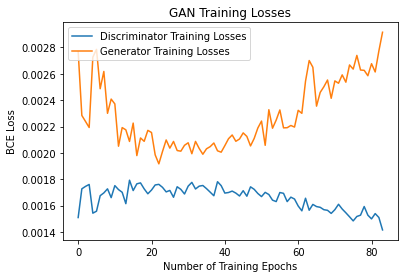

In [29]:
# ANSWER FOR PART 2.2 IN THIS CELL*
epoch = list(range(num_epochs))


plt.figure()
plt.plot(epoch, train_losses_D, label="Discriminator Training Losses")
plt.plot(epoch, train_losses_G, label="Generator Training Losses")
plt.legend(loc="upper left")
plt.title("GAN Training Losses")
plt.xlabel("Number of Training Epochs")
plt.ylabel("BCE Loss")
plt.show()

### Discussion

Do your loss curves look sensible? What would you expect to see and why?

**YOUR ANSWER**

Using my earlier architectures, the discriminator's loss was much (approx. 10 times) lower than the generator's loss. (image included in submited file). This seemed sensible, since the generator had not been well trained and its poor ouputs were easily discriminated against.

Having changed the discriminator to a simpler, more rapidly trainable architeture, and and the generator to a more sophisticated and powerful architecture, the gap between their losses closed. This was to be expected.

Moving on now to the general shape of both losses, it is stable at times, with minor fluctuations, and at other times when the generator loss is decreasing the discriminator loss is increasing and vice versa. This makes sense, since generator and discriminator are competing against each other: Improvement of one means deterioration of the other. As they are both improving, their losses remain approximately constant. If one is improving faster than the other, one's loss is decreasing and the other's is increasing.

Regarding the fact that in later epochs the losses seem to be diverging, with the generator's loss increasing, I am not sure why that is. Perhaps the generator needs an even more sophisticated architecture to further improve.

## Part 2.3: Understanding Mode Collapse (5 points) 
**Your task:** 

Based on the images created by your generator using the `fixed_noise` vector during training, provide a discussion on whether you noticed any mode collapse, what this behaviour may be attributed to, and explain what you did in order to cope with mode collapse.

In [ ]:
# Any additional code

### Discussion


**YOUR ANSWER**

In GANs the generator is tempted to repeatedly produce the same output or a small set of outputs. Normally, this is avoided thanks to the generator learning to always reject this repeated output. Sometimes however, the discriminator may get stuck in a local minimum and be unable to learn this strategy. As a result, the generator cyclically produces the same set of outputs. This phenomenon is referred to as mode collapse.

A way to avoid mode collapse is by using the Wasserstein loss whereby the discriminator tries to maximize the difference between its output on real instances and its output on fake instances and the generator tries to maximize the discriminator's output for its fake instances. (Now however, the discriminator is not classifying images as true or false anymore so it is really a critic, not a discriminator). Wasserstein loss has the advantage of evading vanishing gradients, thus not allowing the discriminator to get stuck in a local minimum so easily, thus preventing mode collapse.

Another way to prevent mode collapse is by using unrolled GANs, whereby the loss of the generator also embodies outputs of a furture optimal discriminator. Then, the generator is no longer tempted to repeatedly ouput the same set of outputs, as the optimal discriminator would just reject them.

Having observed the images created by my generator using the fixed_noise vector during training, I do not think that it suffers from mode collapse. For example, it seems to try and produce images of both cars and animals and it does not seem to produce the same image twice. I am not sure how come but I suspect that it has something to do with the dataset being rather varied, (i.e. I would expect mode collapse to happen more easily on the MNIST dataset). 



# TA Test Cell
TAs will run this cell to ensure that your results are reproducible, and that your models have been defined suitably. 

<font color="blue"> <b> Please provide the input and output transformations required to make your VAE and GANs work. If your GAN generator requires more than just noise as input, also specify this below (there are two marked cells for you to inspect) </b></font>


In [65]:
# If you want to run these tests yourself, change directory:
%cd icl_dl_cw2/

/content/drive/MyDrive/icl_dl_cw2


In [66]:
!pip install -q torch torchvision

In [67]:
# Do not remove anything here
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, sampler
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
import torch.nn.functional as F
import matplotlib.pyplot as plt 

show = lambda img: plt.imshow(np.transpose(img.cpu().numpy(), (1,2,0)))

device = torch.device("cuda"  if torch.cuda.is_available() else "cpu")

# Do not change this cell!
torch.backends.cudnn.deterministic = True
torch.manual_seed(0)

In [68]:
############# CHANGE THESE (COPY AND PASTE FROM YOUR OWN CODE) #############
vae_transform = transforms.Compose([
    transforms.ToTensor(),
])

def vae_denorm(x):
    return x

def gan_denorm(x):
    return x

gan_latent_size = 100

# If your generator requires something other than noise as input, please specify
# two cells down from here

In [69]:
# Load VAE Dataset
test_dat = datasets.MNIST("./data/", train=False, transform=vae_transform, 
                          download=True)
vae_loader_test = DataLoader(test_dat, batch_size=32, shuffle=False)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


In [74]:
############# MODIFY IF NEEDED #############
vae_input, _ = next(iter(vae_loader_test))

# If your generator is conditional, then please modify this input suitably
input_noise = torch.randn(100, gan_latent_size, 1, 1, device=device)
gan_input = [input_noise] # In case you want to provide a tuple, we wrap ours

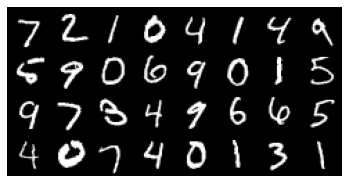

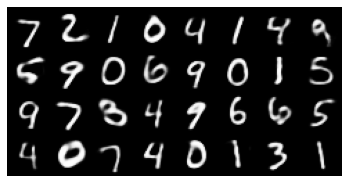

In [72]:
# VAE Tests
# TAs will change these paths as you will have provided the model files manually
"""To TAs, you should have been creating a folder with the student uid
   And the .ipynb + models in the root. Then that path is './VAE_model.pth' etc.
"""
vae = model_G = torch.jit.load('./CW_VAE/VAE_model.pth')
vae.eval()

# Check if VAE is convolutional

for module in vae.children():
    for layer in module.children():
        if "Conv2d" in layer.original_name:
            print("Used Convs")
            break

vae_in = make_grid(denorm(vae_input), nrow=8, padding=2, normalize=False,
                range=None, scale_each=False, pad_value=0)
plt.figure()
plt.axis('off')
show(vae_in)

vae_test = vae(vae_input.to(device))[0].detach()
vae_reco = make_grid(denorm(vae_test), nrow=8, padding=2, normalize=False,
                range=None, scale_each=False, pad_value=0)
plt.figure()
plt.axis('off')
show(vae_reco)

Number of Parameters is 13977537 which is ok


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


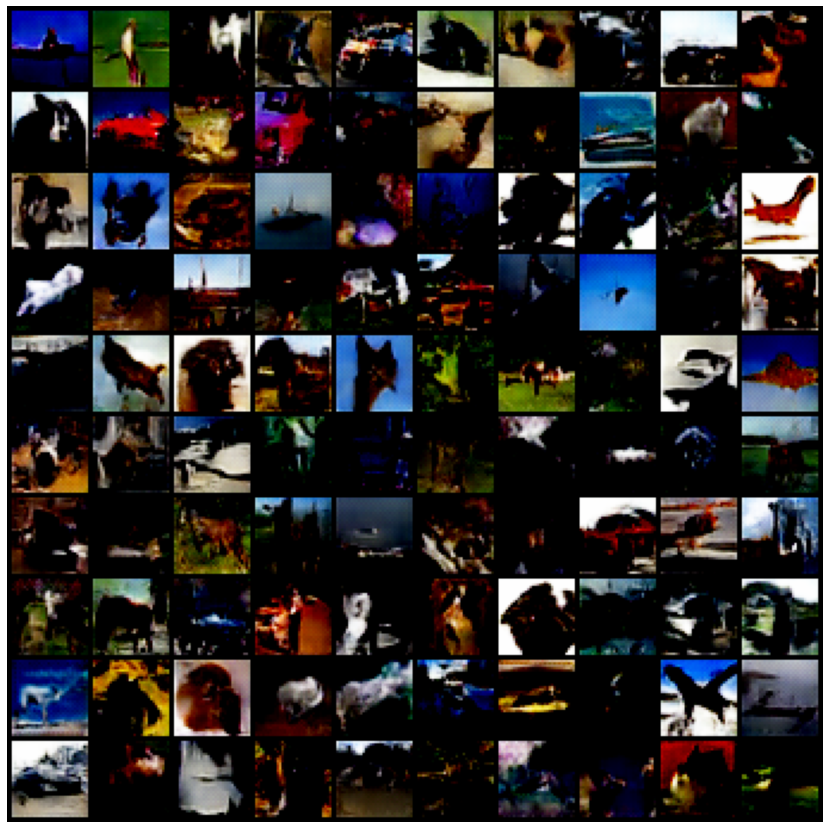

In [75]:
# GAN Tests
model_G = torch.jit.load('./CW_GAN/GAN_G_model.pth')
model_D = torch.jit.load('./CW_GAN/GAN_D_model.pth')
[model.eval() for model in (model_G, model_D)]  

# Check that GAN doesn't have too many parameters
num_param = sum(p.numel() for p in [*model_G.parameters(),*model_D.parameters()])

print(f"Number of Parameters is {num_param} which is", "ok" if num_param<25E+6 else "not ok")

# visualize the generated images
generated = model_G(*gan_input).cpu()
generated = make_grid(gan_denorm(generated)[:100].detach(), nrow=10, padding=2, normalize=False, 
                    range=None, scale_each=False, pad_value=0)
plt.figure(figsize=(15,15))
plt.axis('off')
show(generated)